In [1]:
!nvidia-smi

Mon Jan 31 12:54:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 30%   31C    P2    29W / 350W |  10075MiB / 24259MiB |     26%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install ltp
!pip install -q -U watermark
!pip install -qq transformers
!pip install seaborn
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

numpy       : 1.20.3
pandas      : 1.3.4
torch       : 1.10.0
transformers: 4.7.0



In [3]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from collections import Counter
import ast
import random
import json
from math import isnan


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## New Section

In [4]:
from transformers import BertTokenizer,BertModel
PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"

# PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext-large"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-bert-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
# PRE_TRAINED_MODEL_NAME = "ProsusAI/finbert"
# PRE_TRAINED_MODEL_NAME = "bert-base-chinese"

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True)
PRE_TRAINED_MODEL_NAME = '/home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin'

## Generating the masks of verb, A0, A1

In [5]:
df_train = pd.read_csv('../data/pre/train.csv',sep='\t')
df_val = pd.read_csv('../data/pre/val.csv',sep='\t')
df_test = pd.read_csv('../data/pre/test.csv',sep='\t')
df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')

df_train = df_train.drop(df_train.loc[df_train.verbA0A1.isna()].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1.isna()].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)

df_train = df_train.drop(df_train.loc[df_train.verbA0A1=='[]'].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1=='[]'].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1=='[]'].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)

def string_to_tuples_list(text):
  if text is np.nan or text =='[]':
    return []
  text = ''.join(text.split('], ['))
  tmp = eval(text.strip('[').strip(']'))
  if not isinstance(tmp[0],tuple):
    return [tmp]
  return list(tmp)

for col in ['verb','A0','A1']:
  df_train[col] = df_train[col].apply(string_to_tuples_list)
  df_val[col] = df_val[col].apply(string_to_tuples_list)
  df_test[col] = df_test[col].apply(string_to_tuples_list)
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
# for col in ['verbA0A1']:
  df_train[col] = df_train[col].apply(ast.literal_eval)
  df_val[col] = df_val[col].apply(ast.literal_eval)
  df_test[col] = df_test[col].apply(ast.literal_eval)
  df_ood[col] = df_ood[col].apply(ast.literal_eval)

def mask(df):
  df = df.reset_index(drop = True)
  df['verb_mask'] = 0
  df['A0_mask'] = 0
  df['A1_mask'] = 0
  df['verb_mask'] = df['verb_mask'].astype('object')
  df['A0_mask'] = df['A0_mask'].astype('object')
  df['A1_mask'] = df['A1_mask'].astype('object')
  for index,row in df.iterrows():

    df.at[index,'stock_factors'] = [*map(float,df.loc[index,'stock_factors'])]
    AV_num = 0
    for k,col in enumerate(['verb','A0','A1']):
      masks = []
      for j in range(len(row['verbA0A1'])):
        mask = np.zeros(299)
        idx = []
        for v in row['verbA0A1'][j][k]:
          
          idx = idx + [int(i) for i in range(v[0],v[0]+v[1])]
        # idx = np.unique(idx).tolist()
        counter = Counter(idx)

        mask = [0 if counter[i]== 0 else 1/len(counter) for i in range(0,len(mask))]
        mask.insert(0,0)
        masks.append(mask)
      AV_num = len(masks)
      for i in range(10 - len(masks)):
        masks.append(np.zeros(300))
      while len(masks)>10:
        masks.pop()
      name = col+'_mask'
      df.at[index,name] = np.array(masks)
    if AV_num>10:
      AV_num=10
    df.loc[index,'AV_num'] = int(AV_num)
  df.AV_num = df.AV_num.astype('int')
  df.stock_factors = df.stock_factors.apply(np.array)
  return df


df_train = mask(df_train)
df_test = mask(df_test)
df_val = mask(df_val)
df_ood = mask(df_ood)

In [6]:
# max(df_train.verb_mask.apply(len))

In [7]:
# df_train.to_csv('./data/df_train_srl.csv',sep='\t',index=None)
# df_test.to_csv('./data/df_test_srl.csv',sep='\t',index=None)
# df_val.to_csv('./data/df_val_srl.csv',sep='\t',index=None)
# df_ood.to_csv('./data/df_ood_srl.csv',sep='\t',index=None)

/home/bit/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'review score')

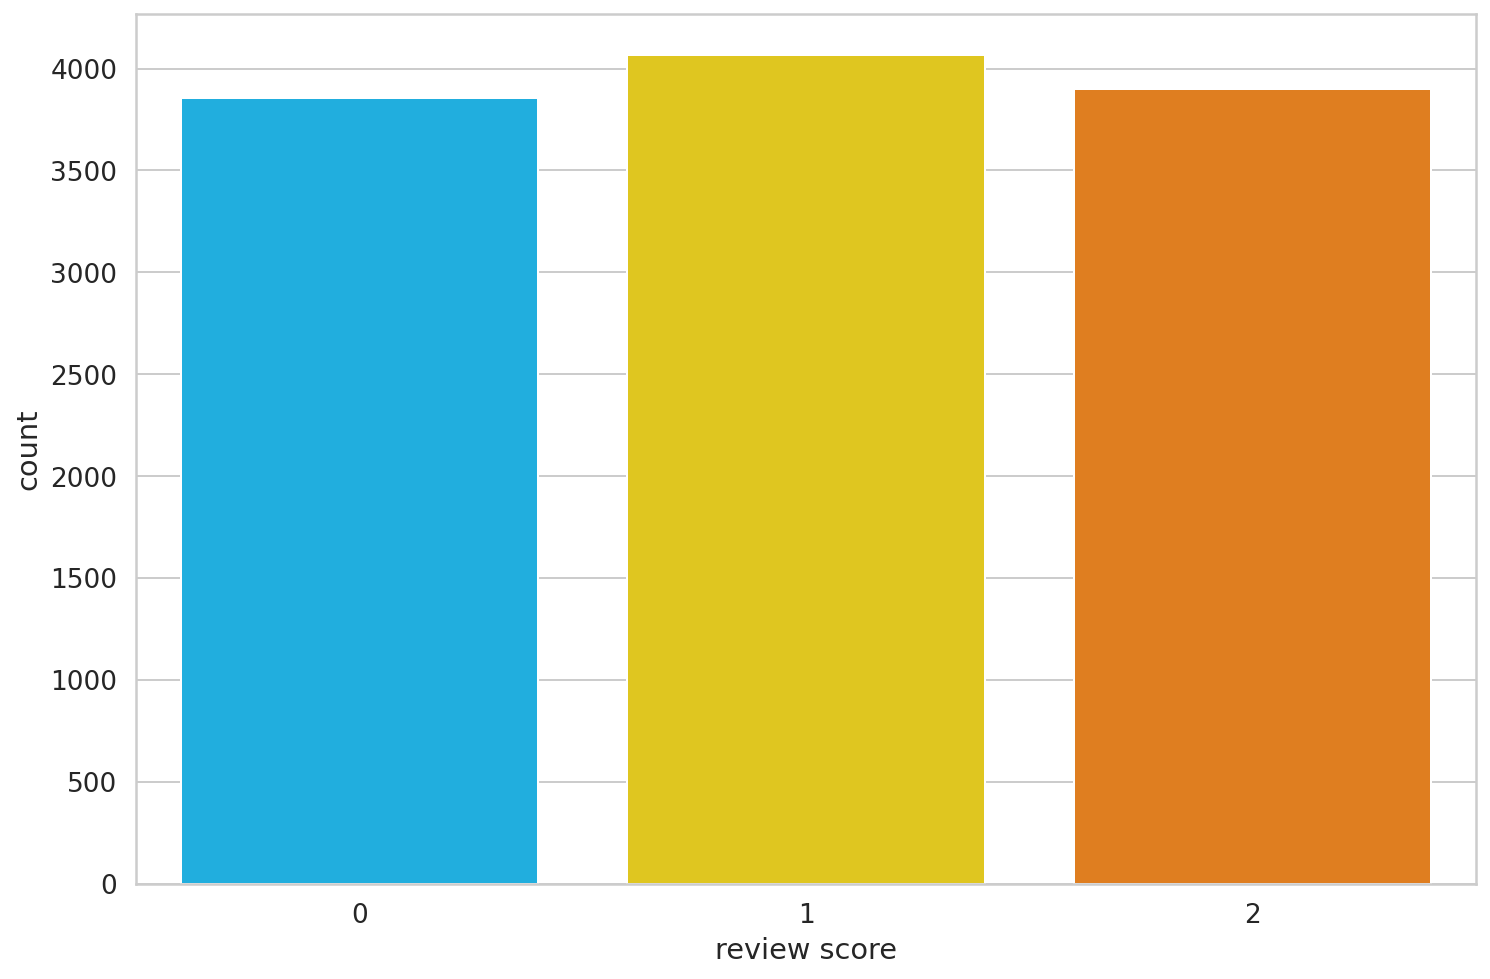

In [8]:
sns.countplot(df_train.label)
plt.xlabel('review score')

In [9]:
total = pd.concat([df_train,df_test,df_val])

In [10]:
total.sort_values(by='DATE')

,CODE,DATE,label,text_a,verb,A0,A1,verbA0A1,verb_mask,A0_mask,...,day2,open3,close3,day3,open4,close4,day4,open5,close5,day5
1456,2699,2018-07-23 18:31:00,2,美盛文化(sz002699)公告，拟发起设立康元人寿保险股份有限公司，公司出资额为4亿元，占...,"[(14, 1), (17, 2), (37, 1), (42, 1)]","[(32, 2), (34, 3), (32, 2), (34, 3)]","[(15, 2), (17, 2), (19, 2), (21, 4), (25, 2), ...","[[[(37, 1)], [(32, 2), (34, 3)], [(38, 2), (40...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,2018-07-26,18.0000,17.9500,2018-07-27,18.0500,17.5900,2018-07-30,17.5800,17.6000,2018-07-31
5345,601668,2018-07-23 18:36:00,2,中国建筑晚间发布公告，近期本公司获得广东珠海横琴科学城、澳大利亚复华耀世 SPIRIT 项目...,"[(6, 2), (16, 2), (69, 1)]","[(0, 2), (2, 2), (56, 2), (58, 2), (13, 1), (1...","[(70, 1), (71, 2), (73, 2), (75, 2), (77, 1), ...","[[[(6, 2)], [(0, 2), (2, 2)], [(8, 2)]], [[(16...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5,...","[[0.0, 0.25, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0, ...",...,2018-07-26,5.1257,5.1436,2018-07-27,5.1526,5.2422,2018-07-30,5.1974,5.1974,2018-07-31
2098,2636,2018-07-24 01:25:00,2,金安国纪(sz002636)公告，今年以来，覆铜板市场发生了较大的变化，电子电路产业深层次发...,"[(24, 2), (28, 1), (47, 2), (56, 2), (106, 2),...","[(30, 2), (54, 2), (27, 1), (28, 1), (29, 1), ...","[(49, 2), (51, 2), (102, 1), (103, 3), (19, 3)...","[[[(24, 2)], [(19, 3), (22, 2)], [(27, 1), (28...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,2018-07-26,9.5300,9.4700,2018-07-27,9.4200,9.2900,2018-07-30,9.2100,9.4400,2018-07-31
4613,2243,2018-07-24 02:57:00,0,通产丽星(sz002243)异动公告称，公司富勒烯碳纳米工程实验室取得的研究成果处于实验室阶...,"[(15, 1), (30, 2), (37, 2), (45, 2), (60, 2), ...","[(0, 4), (4, 1), (5, 5), (10, 1), (11, 4), (17...","[(47, 3), (50, 1), (51, 3), (54, 1), (55, 2), ...","[[[(15, 1)], [(0, 4), (4, 1), (5, 5), (10, 1),...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.06666666666666667, 0.0666666666666666...",...,2018-07-26,10.1917,10.2704,2018-07-27,10.0343,9.2965,2018-07-30,9.0899,8.9030,2018-07-31
625,300024,2018-07-24 02:57:00,1,美的集团斥资约40亿元回购股票事宜在今天（7月23日）下午的股东大会上获得通过。在回答投资人...,"[(4, 2), (10, 2), (33, 2), (39, 2), (60, 2), (...","[(0, 1), (1, 1), (2, 2), (0, 1), (1, 1), (2, 2...","[(12, 2), (41, 3), (44, 1), (45, 2), (6, 3), (...","[[[(4, 2)], [(0, 1), (1, 1), (2, 2)], [(6, 3),...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0,...","[[0.0, 0.25, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0, ...",...,2018-07-26,17.4000,17.3700,2018-07-27,17.3600,17.0500,2018-07-30,17.1000,17.0900,2018-07-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,300246,2020-12-31 20:20:00,1,宝莱特披露2021年限制性股票激励计划(草案)，该激励计划拟授予的限制性股票数量为280万股...,"[(3, 2), (26, 1), (27, 2), (37, 1), (42, 1), (...","[(0, 3), (21, 1), (22, 2), (24, 2), (26, 1), (...","[(27, 2), (33, 2), (67, 2), (69, 2), (71, 2), ...","[[[(3, 2)], [(0, 3)], [(5, 2), (7, 3), (10, 2)...","[[0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0,...","[[0.0, 0.3333333333333333, 0.3333333333333333,...",...,2021-01-06,26.2456,25.0214,2021-01-07,24.7864,25.4425,2021-01-08,25.5503,26.1085,2021-01-11
5358,300008,2020-12-31 21:05:00,2,天海防务公告，公司收到法院民事裁定书，裁定公司重整计划执行完毕。天海防务表示，重整计划的执行...,"[(9, 2), (27, 2), (29, 2), (36, 2), (48, 2), (...","[(7, 2), (32, 4), (39, 2), (41, 2), (43, 1), (...","[(21, 2), (23, 2), (25, 2), (76, 2), (78, 2), ...","[[[(9, 2)], [(7, 2)], [(11, 2), (13, 2), (15, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5,...",...,2021-01-06,7.0800,7.2500,2021-01-07,7.2600,6.7600,2021-01-08,6.9600,6.6400,2021-01-11
3551,300087,2020-12-31 21:17:00,2,荃银高科公告，股东贾桂兰、王玉林将所持公司全部股份（占公司总股本8.23%）的表决权委托给公...,"[(26, 1), (41, 2), (72, 2), (84, 1), (96, 2), ...","[(7, 2), (9, 3), (12, 1), (13, 3), (127, 2), (...","[(27, 2), (29, 1), (30, 2), (98, 2), (100, 2),...","[[[(41, 2)], [(7, 2), (9, 3), (12, 1), (13, 3)...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11...",...,2021-01-06,35.9857,3

## Creat Dataloader

In [11]:
max_len = 300
class_names = ['negative','neutral', 'positive']
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets,verb,A0,A1,AV_num,tokenizer,stock_factors, max_len):
    self.reviews = reviews
    self.targets = targets
    self.stock_factors = stock_factors
    self.verb = verb
    self.A0 = A0
    self.A1 = A1
    self.AV_num = AV_num
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    stock_factors = self.stock_factors[item]
    v = self.verb[item]
    a0 = self.A0[item]
    a1 = self.A1[item]
    av_num = self.AV_num[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'stock_factors':torch.tensor(stock_factors),
      'verb': torch.tensor(v),
      'A0': torch.tensor(a0),
      'A1': torch.tensor(a1),
      'AV_num': torch.tensor(av_num)
    }

In [12]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text_a.to_numpy(),
    targets=df.label.to_numpy(),
    stock_factors = df.stock_factors,
    verb = df.verb_mask,
    A0 = df.A0_mask,
    A1 = df.A1_mask,
    AV_num = df.AV_num,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    # num_workers=4,
    shuffle=True
  )

In [13]:

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_ood = df_ood.reset_index(drop=True)

In [14]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

## Model

In [15]:
NUMBER_FACTOR = 24
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.encoder_layer =  nn.TransformerEncoderLayer(d_model=2304+NUMBER_FACTOR, nhead=1)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
    self.drop = nn.Dropout(p=0.1)
    # self.L1 = nn.Linear(self.bert.config.hidden_size*30, self.bert.config.hidden_size*3)
    self.out1 = nn.Linear((self.bert.config.hidden_size*3+NUMBER_FACTOR)*10, (self.bert.config.hidden_size*3+NUMBER_FACTOR)*3)
    self.out = nn.Linear((self.bert.config.hidden_size*3+NUMBER_FACTOR)*3, n_classes)
    self.linear_for_stock_factors = nn.Linear(NUMBER_FACTOR,NUMBER_FACTOR)
    self.flatten2 = nn.Flatten(2,-1)
    self.flatten = nn.Flatten(1,-1)
    self.relu = nn.ReLU()
    self.sig = nn.Sigmoid()
    self.Querry = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size)
    self.Key = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size)
    # self.Self_supervised = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size)

  
  def forward(self, input_ids, attention_mask,verb,A0,A1,stock_factors,AV_num):
    #get bert embedding 
    hidden_state = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[0]
    batch = hidden_state.shape[0]
    verb_tmp = verb.clone()

    #stock_factor(8*24)
    stock_factors_batch = stock_factors[:,:NUMBER_FACTOR]
    stock_factors_batch = self.linear_for_stock_factors(stock_factors_batch.float())
    stock_factors_batch = self.relu(stock_factors_batch)
    stock_factors_batch = torch.unsqueeze(stock_factors_batch,1) #8*1*2304
    stock_factors_batch= torch.cat(10*[stock_factors_batch],1)

    A1_tmp = A1.clone()

    #mask verb
    AV_idx = []
    for idx,num in enumerate(AV_num):
      self_label = torch.randint(0,num,(1,))[0]
      AV_idx.append(self_label)
      A1_tmp[idx,self_label,:]=0
      stock_factors_batch[idx] = torch.cat(num*[torch.unsqueeze(stock_factors_batch[idx][0],0)]+(10-num)*[torch.zeros((1,NUMBER_FACTOR)).to(device)])


     #verb label
    AV_idx = torch.tensor(AV_idx).to(device)

    A1_mask = torch.unsqueeze(A1,3)
    A1_mask = torch.cat(768 * [A1_mask],3)
    A1_mask = torch.mean(A1_mask*torch.unsqueeze(hidden_state,1),2,True)

    K = self.Key(torch.squeeze(A1_mask.float()))
    
    # get verb embedding after masking(8*10*1*768)
    
    V_mask = torch.unsqueeze(verb,3)
    V_mask = torch.cat(768 * [V_mask],3)
    V_mask = torch.mean(V_mask*torch.unsqueeze(hidden_state,1),2,True)
    transformer_input = V_mask

    #get A0 embedding(8*10*2*768)
    A0_mask = torch.unsqueeze(A0,3)
    A0_mask = torch.cat(768 * [A0_mask],3)
    A0_mask = torch.mean(A0_mask*torch.unsqueeze(hidden_state,1),2,True)
    transformer_input = torch.cat([transformer_input,A0_mask],2)

    #get A1 embedding(8*10*3*768)
    A1_mask_mask = torch.unsqueeze(A1_tmp,3)
    A1_mask_mask = torch.cat(768 * [A1_mask_mask],3)
    A1_mask_mask = torch.mean(A1_mask_mask*torch.unsqueeze(hidden_state,1),2,True)
    transformer_input = torch.cat([transformer_input,A1_mask_mask],2)

    #get transformer input(8*10*2304)
    transformer_input = self.flatten2(transformer_input.float())
    transformer_input = torch.cat([transformer_input,stock_factors_batch],2)


    #turn to (11*8*2304)
    transformer_input = torch.stack([transformer_input[:,i,:] for i in range(0,len(verb[0]))])
    
    #get transformer output(11*8*2304)
    transformer_output = self.transformer_encoder(transformer_input)

    #turn to (8*11*2304)
    transformer_output = torch.stack([torch.squeeze(transformer_output[:,i,:]) for i in range(0,batch)])
    transformer_output = torch.squeeze(transformer_output)

    #turn to (8*11*2304)
    self_pred = torch.zeros((batch,10))
    if transformer_output.dim()==2:
      transformer_output = torch.unsqueeze(transformer_output,0)

    output = self.flatten(transformer_output.float())
    output = self.sig(output)
#     output = self.drop(output)
    output = self.out1(output)
    output = self.sig(output)
    output = self.drop(output)
    output = self.out(output)
    
    return output,self_pred,AV_idx

In [16]:
model = SentimentClassifier(3)
model = model.to(device)

Some weights of the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin and are new

In [17]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=2,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)
# loss_fn = nn.KLDivLoss(reduce=False,size_average=False).to(device)

In [18]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  correct_predictions_verbs = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    stock_factors = d['stock_factors'].to(device)
    verb = d["verb"].to(device)
    A0 = d["A0"].to(device)
    A1 = d["A1"].to(device)
    AV_num = d["AV_num"].to(device)

    outputs,self_outputs,self_labels = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      verb = verb,
      A0 = A0,
      A1 = A1,
      stock_factors = stock_factors,
      AV_num = AV_num
    )
    self_outputs = self_outputs.to(device)
    self_labels = self_labels.to(device)



    if outputs.dim()==1:
      outputs = torch.unsqueeze(outputs,0)
    _, preds = torch.max(outputs, dim=1)
    _, self_preds = torch.max(self_outputs, dim=1)

    # print(targets.shape,outputs.shape)
    loss = 0.8*loss_fn(outputs, targets)+0.2*loss_fn(self_outputs,self_labels)

    correct_predictions += torch.sum(preds == targets)
    correct_predictions_verbs += torch.sum(self_preds == self_labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses),correct_predictions_verbs.double()/n_examples

In [19]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      stock_factors = d['stock_factors'].to(device)
      verb = d["verb"].to(device)
      A0 = d["A0"].to(device)
      A1 = d["A1"].to(device)
      AV_num = d["AV_num"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        verb = verb,
        A0 = A0,
        A1 = A1,
        stock_factors = stock_factors,
        AV_num = AV_num
      )[0]
      
      if outputs.dim()==1:
        outputs = torch.unsqueeze(outputs,0)
      _, preds = torch.max(outputs, dim=1)
      
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:
history = defaultdict(list)
best_accuracy = 0
best_train_accuracy = 0
# EPOCHS = 5

In [21]:
%%time

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss, cl_acc = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc} cl_accuracy{cl_acc}')

  if train_acc > best_train_accuracy:
    torch.save(model.state_dict(), 'best_train_model_state.bin')
    best_train_accuracy = train_acc
    print("save to best train model")

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Factor24_Pretrained_RoBert_SRL(FC)_A1.bin')
    best_accuracy = val_acc
    print("save to best model")

Epoch 1/10
----------
Train loss 1.249347343093165 accuracy 0.5247566652560305 cl_accuracy0.5725772323317816
save to best train model
Val   loss 0.8839095497644076 accuracy 0.5802301963439404

save to best model
Epoch 2/10
----------
Train loss 1.125525980502246 accuracy 0.6302158273381294 cl_accuracy0.5784172661870504
save to best train model
Val   loss 0.8485241074074981 accuracy 0.6316858496953284

save to best model
Epoch 3/10
----------
Train loss 1.074952196365119 accuracy 0.6698264917477782 cl_accuracy0.5753702920016928
save to best train model
Val   loss 0.808022040513254 accuracy 0.6452268111035884

save to best model
Epoch 4/10
----------
Train loss 1.0291161296009534 accuracy 0.7048666948793906 cl_accuracy0.5714769360981803
save to best train model
Val   loss 0.8257145163833454 accuracy 0.6486120514556534

save to best model
Epoch 5/10
----------
Train loss 0.9811666527200938 accuracy 0.7393144308082945 cl_accuracy0.5756242065171392
save to best train model
Val   loss 0.8589

KeyboardInterrupt: 

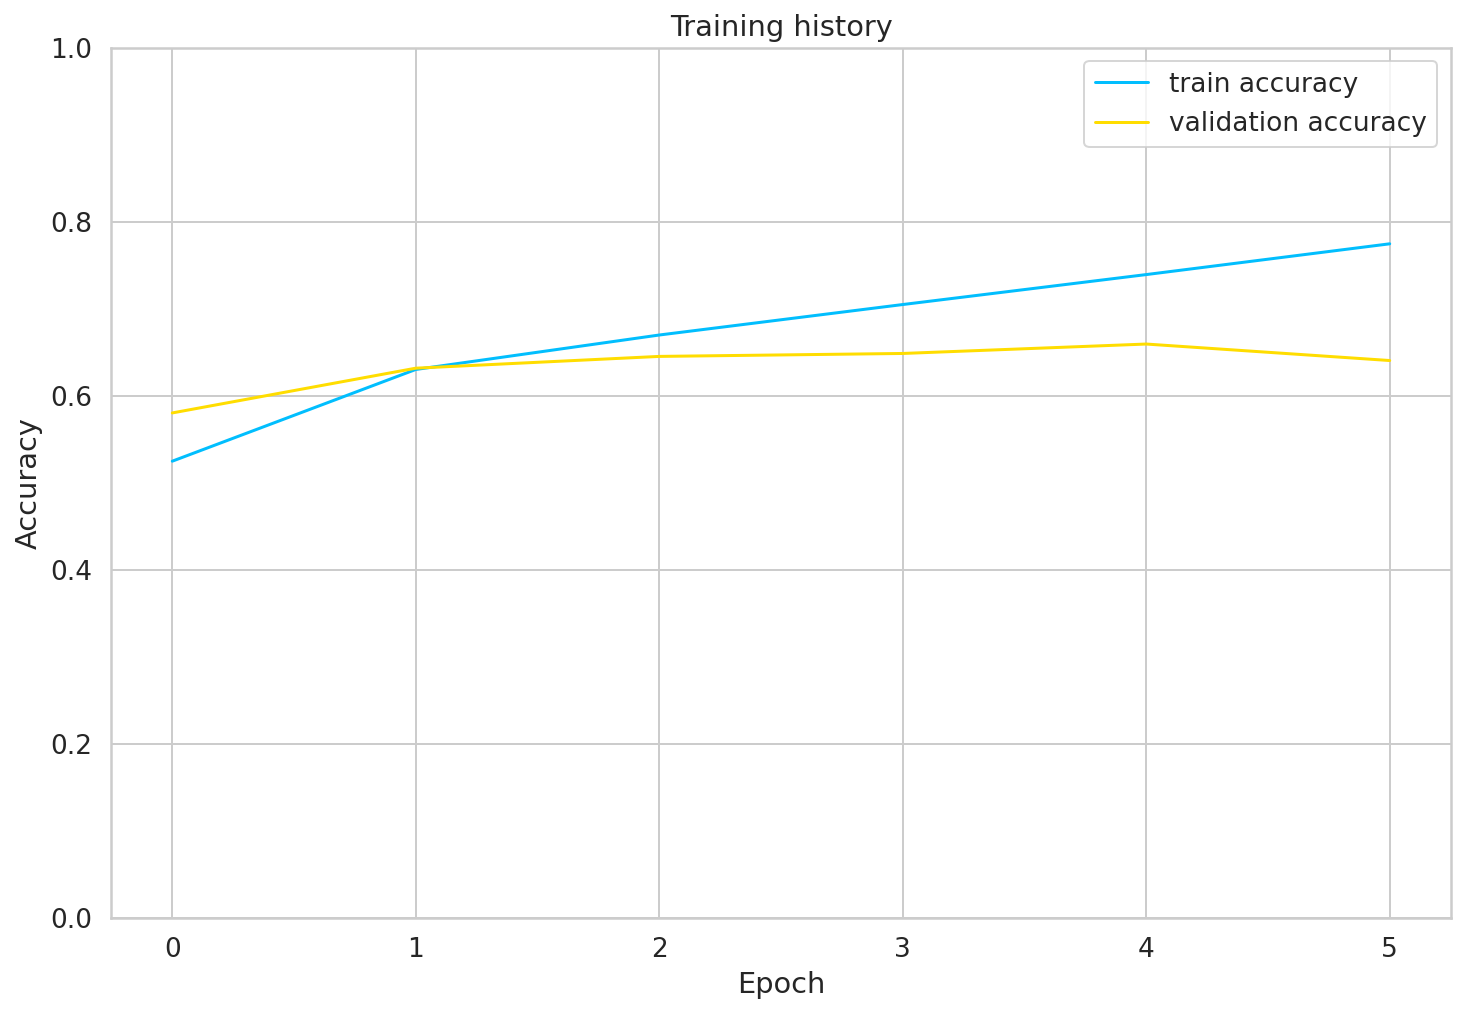

In [22]:
plt.plot([i.cpu() for i in history['train_acc']], label='train accuracy')
plt.plot([i.cpu() for i in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [23]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('Factor24_Pretrained_RoBert_SRL(FC)_A1.bin'))
model = model.to(device)

Some weights of the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin and are new

In [24]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6560595802301963

In [25]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      verb = d["verb"].to(device)
      stock_factors = d['stock_factors'].to(device)
      A0 = d["A0"].to(device)
      A1 = d["A1"].to(device)
      AV_num = d['AV_num'].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        verb = verb,
        A0 = A0,
        A1 = A1,
        stock_factors = stock_factors,
        AV_num = AV_num
      )[0]
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values


              precision    recall  f1-score   support

    negative     0.6713    0.7004    0.6855       484
     neutral     0.6350    0.5960    0.6149       505
    positive     0.6586    0.6721    0.6653       488

    accuracy                         0.6554      1477
   macro avg     0.6550    0.6562    0.6553      1477
weighted avg     0.6547    0.6554    0.6547      1477



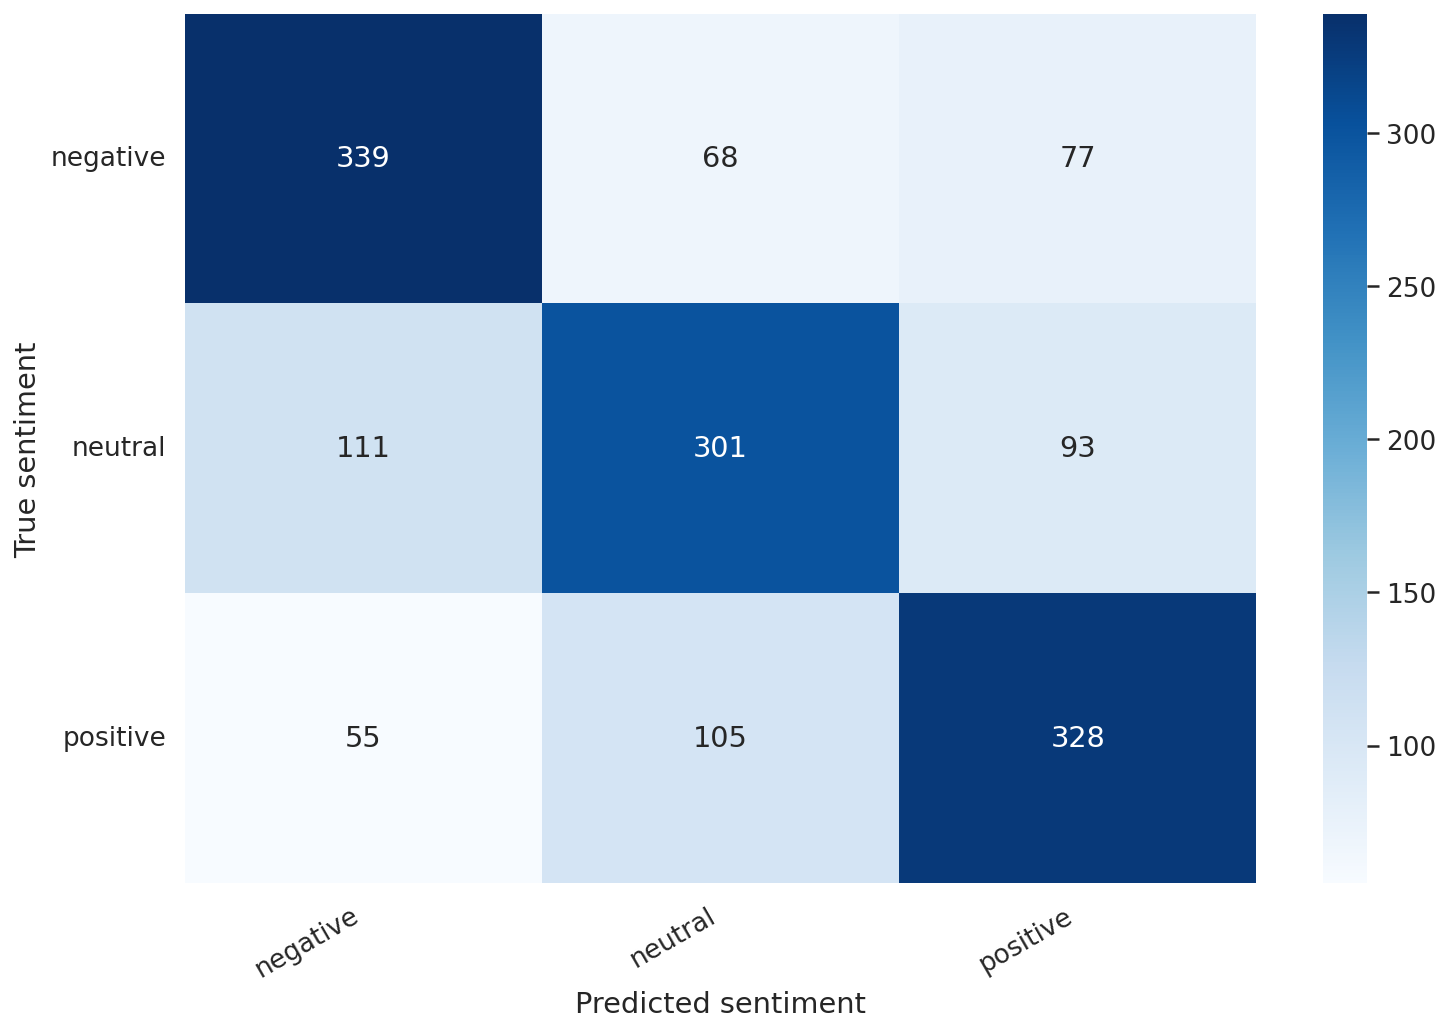

In [26]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# df = pd.DataFrame([y_review_texts, y_pred.numpy(), y_pred_probs.numpy(), y_test.numpy()]).T
# df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
# df.to_csv('/content/drive/MyDrive/data/df_prediction_roberta_srl_cl_f.csv',sep='\t')

print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### OOD Result

              precision    recall  f1-score   support

    negative     0.6875    0.6454    0.6658      3133
     neutral     0.6148    0.5581    0.5851      3406
    positive     0.6195    0.7062    0.6600      3618

    accuracy                         0.6378     10157
   macro avg     0.6406    0.6366    0.6370     10157
weighted avg     0.6389    0.6378    0.6367     10157



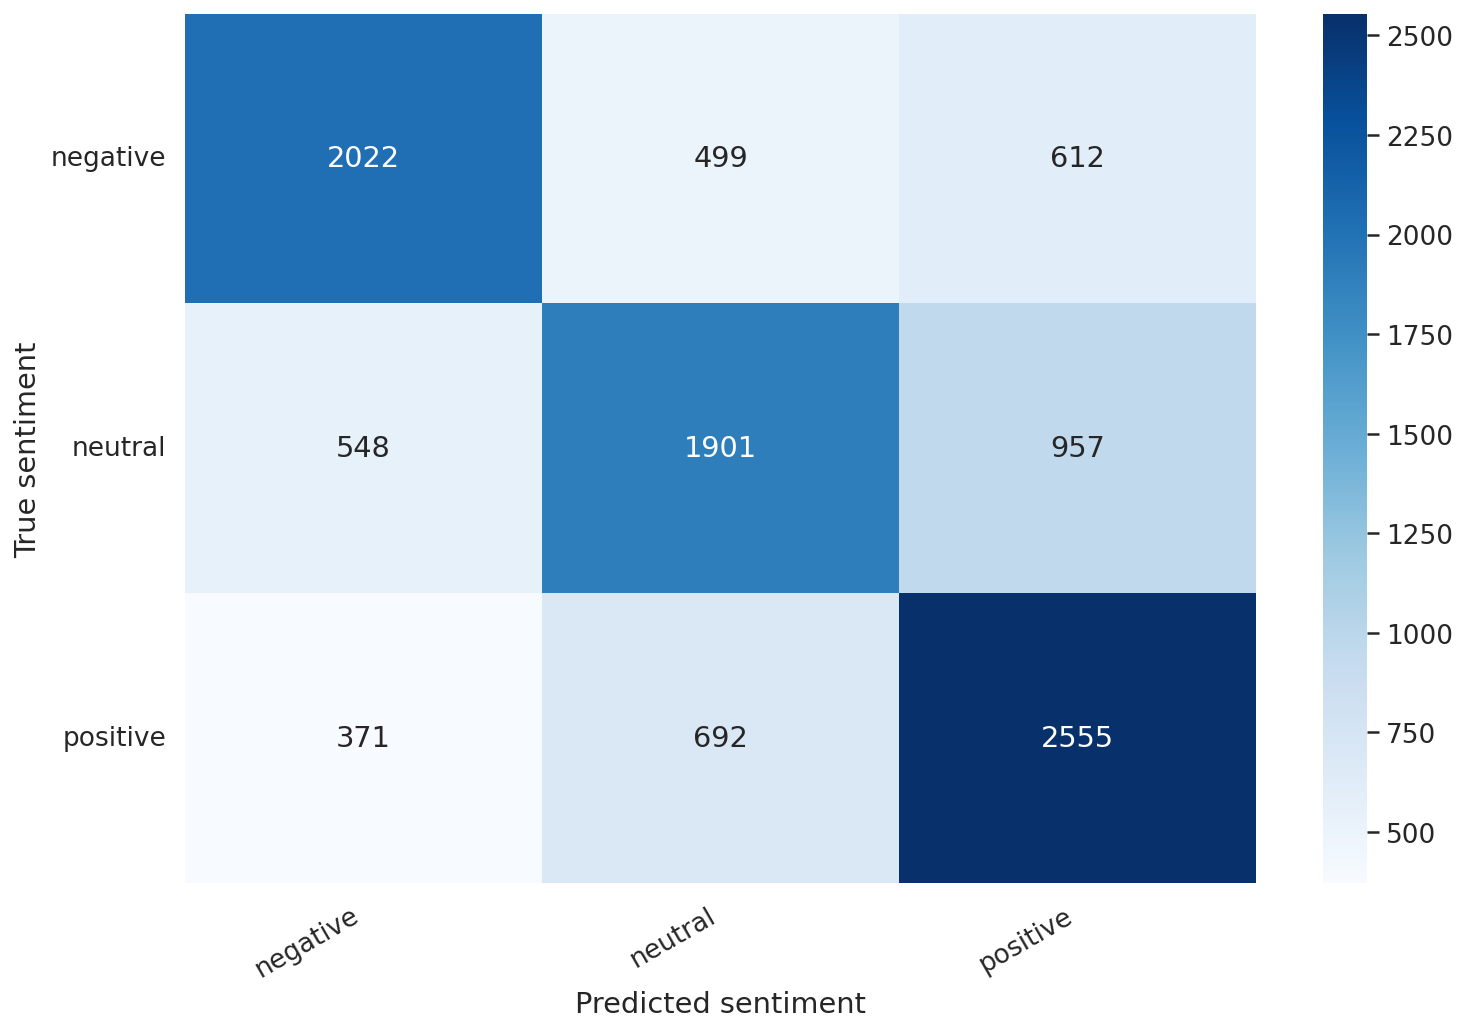

In [27]:
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

              precision    recall  f1-score   support

    negative     0.6861    0.6352    0.6597       943
     neutral     0.5924    0.5750    0.5836       953
    positive     0.6709    0.7203    0.6947      1330

    accuracy                         0.6525      3226
   macro avg     0.6498    0.6435    0.6460      3226
weighted avg     0.6522    0.6525    0.6516      3226



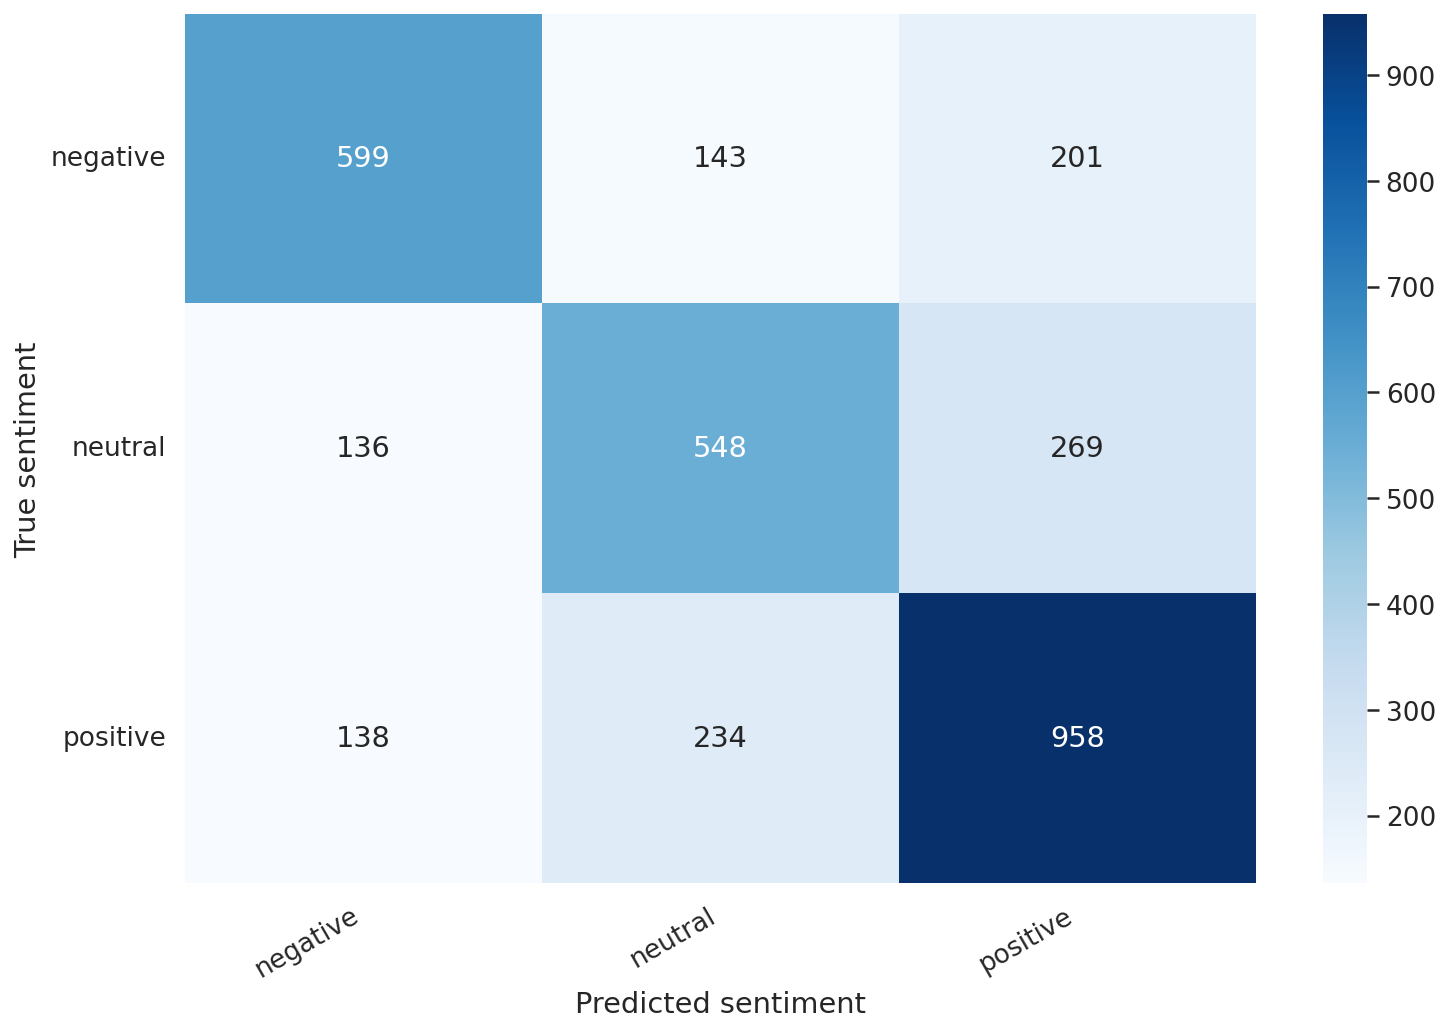

              precision    recall  f1-score   support

    negative     0.6977    0.6854    0.6915       623
     neutral     0.7104    0.6036    0.6527       825
    positive     0.6246    0.7311    0.6736       792

    accuracy                         0.6714      2240
   macro avg     0.6776    0.6734    0.6726      2240
weighted avg     0.6765    0.6714    0.6709      2240



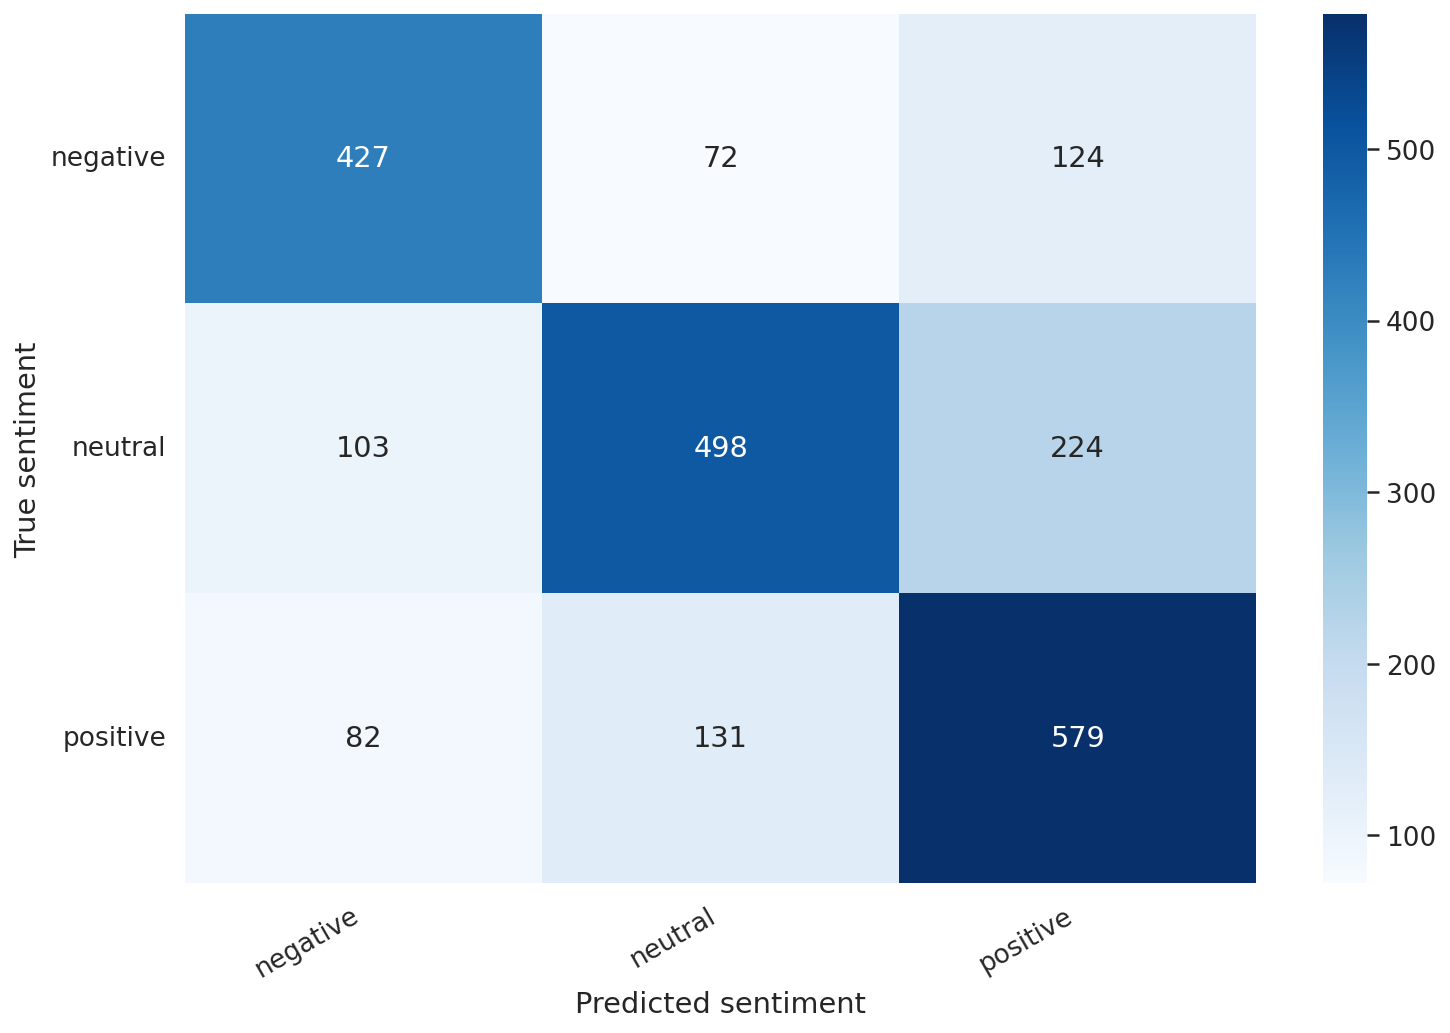

              precision    recall  f1-score   support

    negative     0.6880    0.6327    0.6592      1157
     neutral     0.5849    0.5184    0.5497      1169
    positive     0.5744    0.6932    0.6282      1092

    accuracy                         0.6129      3418
   macro avg     0.6158    0.6148    0.6123      3418
weighted avg     0.6164    0.6129    0.6118      3418



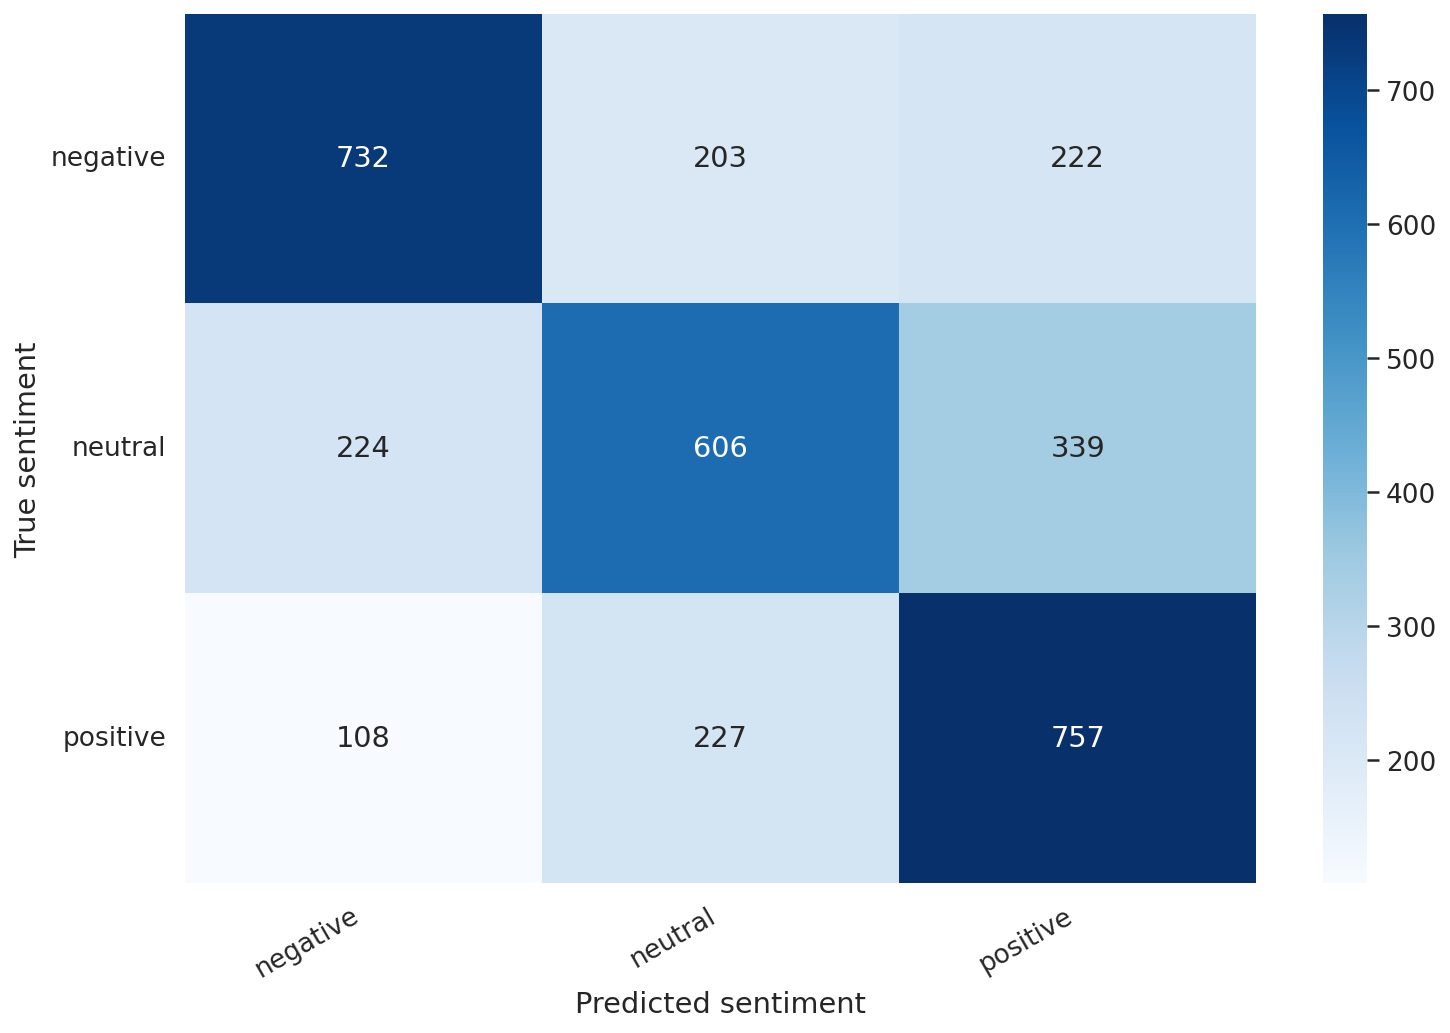

              precision    recall  f1-score   support

    negative     0.6701    0.6386    0.6540       404
     neutral     0.5779    0.5391    0.5579       447
    positive     0.5674    0.6404    0.6017       381

    accuracy                         0.6031      1232
   macro avg     0.6052    0.6061    0.6045      1232
weighted avg     0.6049    0.6031    0.6030      1232



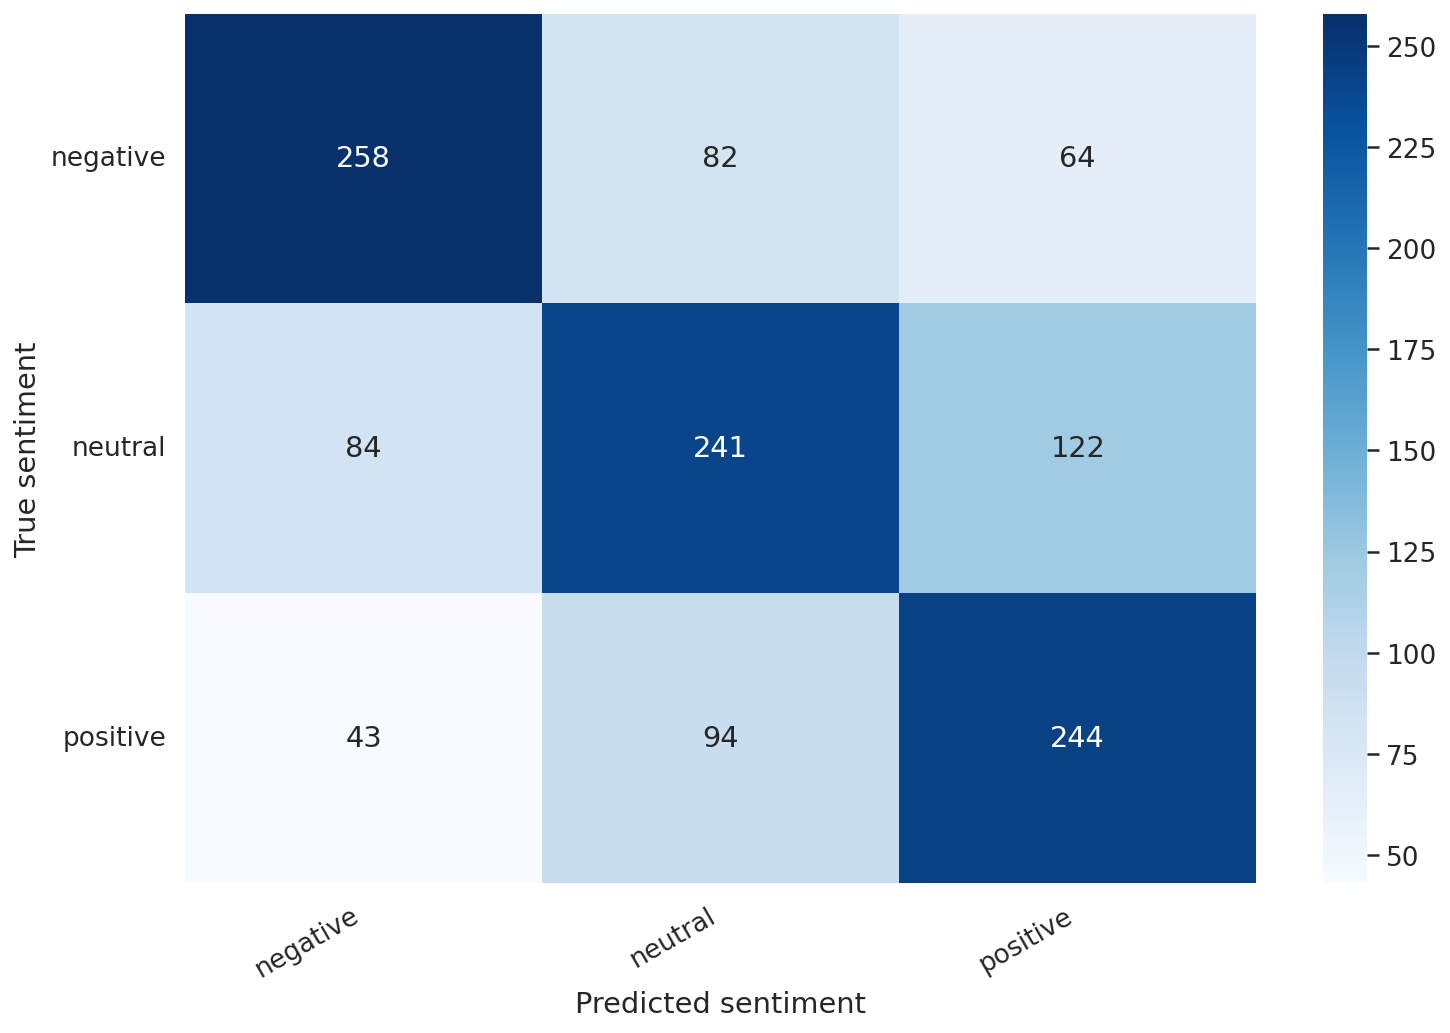

In [28]:
df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-01-01')&(df_ood.DATE<='2021-03-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-04-01')&(df_ood.DATE<='2021-06-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-07-01')&(df_ood.DATE<='2021-09-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[df_ood.DATE>='2021-10-01']
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         0
     neutral     1.0000    0.3539    0.5228     16798
    positive     0.0000    0.0000    0.0000         0

    accuracy                         0.3539     16798
   macro avg     0.3333    0.1180    0.1743     16798
weighted avg     1.0000    0.3539    0.5228     16798



/home/bit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


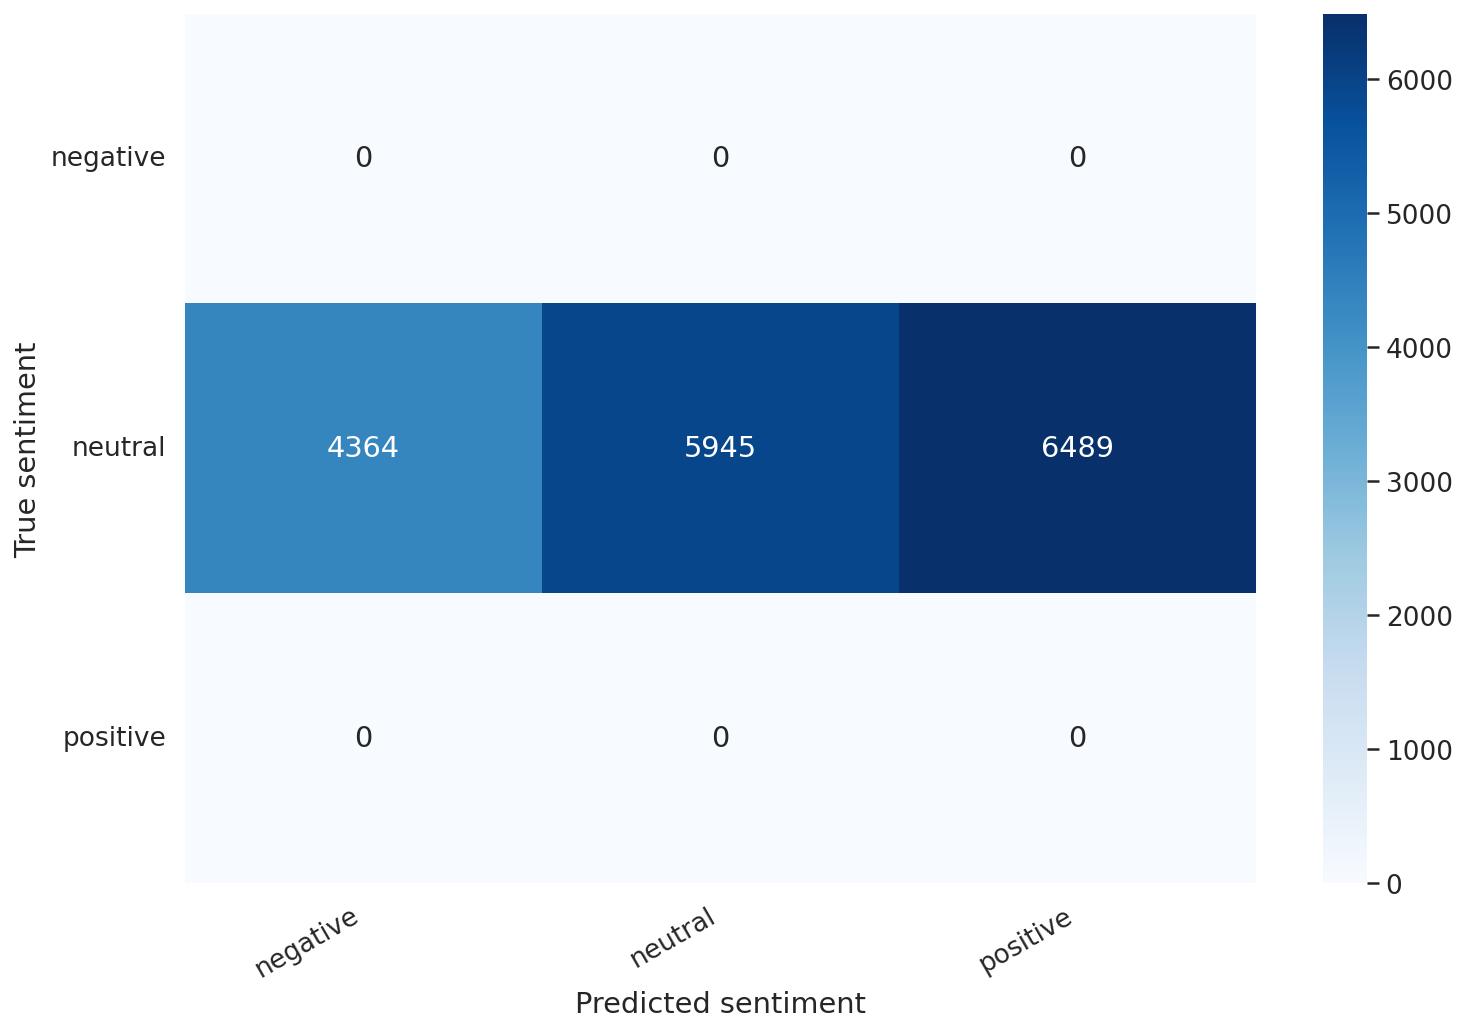

In [29]:
df_ood = pd.read_csv('../data/df_all_year_srl.csv',sep='\t')
# df_ood = df_ood.loc[(df_ood.DATE>='2021-05-05')&(df_ood.DATE<='2021-09-01')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

In [30]:
df = pd.DataFrame([y_ood_review_texts, y_ood_pred.numpy(), y_ood_pred_probs.numpy(), y_ood.numpy()]).T
df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
df.to_csv('Factor24_Pretrained_RoBert_SRL(FC)_A1_ood.csv',sep='\t')

In [31]:
# !pip install lit-nlp

In [32]:
# from lit_nlp.api.dataset import Dataset
# class MultiNLIData(Dataset):
#   """Loader for MultiNLI development set."""
#   def __init__(self, df):
#     # Read the eval set from a .tsv file as distributed with the GLUE benchmark.
#     # df = pandas.read_csv(path, sep='\t')
#     # Store as a list of dicts, conforming to self.spec()
#     self.LABELS = [0,1]
#     self._examples = [{
#       'sentence': row['DESCRIPTION_EN'],
#       # 'hypothesis': row['sentence2'],
#       'label': row['LABEL']
#       # 'genre': row['genre'],
#     } for _, row in df.iterrows()]
#   def spec(self):
#     return {
#       'sentence': lit_types.TextSegment(),
#       # 'hypothesis': lit_types.TextSegment(),
#       'label': lit_types.CategoryLabel(vocab=self.LABELS),
#       # We can include additional fields, which don't have to be used by the model.
#       # 'genre': lit_types.Label(),
#     }

In [33]:
# from absl import app
# from absl import flags
# from absl import logging

# from lit_nlp import dev_server
# from lit_nlp import server_flags
# from lit_nlp.api import model as lit_model
# from lit_nlp.api import types as lit_types
# # Use the regular GLUE data loaders, because these are very simple already.
# from lit_nlp.examples.datasets import glue
# from lit_nlp.lib import utils

# import torch
# import transformers

# # NOTE: additional flags defined in server_flags.py

# FLAGS = flags.FLAGS

# flags.DEFINE_string(
#     "model_path",
#     "https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz",
#     "Path to trained model, in standard transformers format, e.g. as "
#     "saved by model.save_pretrained() and tokenizer.save_pretrained()")


# def _from_pretrained(cls, *args, **kw):
#   """Load a transformers model in PyTorch, with fallback to TF2/Keras weights."""
#   try:
#     return cls.from_pretrained(*args, **kw)
#   except OSError as e:
#     logging.warning("Caught OSError loading model: %s", e)
#     logging.warning(
#         "Re-trying to convert from TensorFlow checkpoint (from_tf=True)")
#     return cls.from_pretrained(*args, from_tf=True, **kw)


# class SimpleSentimentModel(lit_model.Model):
#   """Simple sentiment analysis model."""

#   LABELS = [0,1]  # negative, positive

#   def __init__(self, model_name_or_path):
#     self.tokenizer = transformers.AutoTokenizer.from_pretrained(
#         model_name_or_path)
#     model_config = transformers.AutoConfig.from_pretrained(
#         model_name_or_path,
#         num_labels=2,
#         output_hidden_states=True,
#         output_attentions=True,
#     )
#     # This is a just a regular PyTorch model.
#     self.model = _from_pretrained(
#         transformers.AutoModelForSequenceClassification,
#         model_name_or_path,
#         config=model_config)
#     self.model.eval()

#   ##
#   # LIT API implementation
#   def max_minibatch_size(self):
#     # This tells lit_model.Model.predict() how to batch inputs to
#     # predict_minibatch().
#     # Alternately, you can just override predict() and handle batching yourself.
#     return 16

#   def predict_minibatch(self, inputs):
#     # Preprocess to ids and masks, and make the input batch.
#     encoded_input = self.tokenizer.batch_encode_plus(
#         [ex["sentence"] for ex in inputs],
#         return_tensors="pt",
#         add_special_tokens=True,
#         max_length=200,
#         padding="longest",
#         truncation="longest_first")

#     # Check and send to cuda (GPU) if available
#     if torch.cuda.is_available():
#       self.model.cuda()
#       for tensor in encoded_input:
#         encoded_input[tensor] = encoded_input[tensor].cuda()
#     # Run a forward pass.
#     with torch.no_grad():  # remove this if you need gradients.
#       out: transformers.modeling_outputs.SequenceClassifierOutput = \
#           self.model(**encoded_input)

#     # Post-process outputs.
#     batched_outputs = {
#         "probas": torch.nn.functional.softmax(out.logits, dim=-1),
#         "input_ids": encoded_input["input_ids"],
#         "ntok": torch.sum(encoded_input["attention_mask"], dim=1),
#         "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
#     }
#     # Return as NumPy for further processing.
#     detached_outputs = {k: v.cpu().numpy() for k, v in batched_outputs.items()}
#     # Unbatch outputs so we get one record per input example.
#     for output in utils.unbatch_preds(detached_outputs):
#       ntok = output.pop("ntok")
#       output["tokens"] = self.tokenizer.convert_ids_to_tokens(
#           output.pop("input_ids")[1:ntok - 1])
#       yield output

#   def input_spec(self) -> lit_types.Spec:
#     return {
#         "sentence": lit_types.TextSegment(),
#         "label": lit_types.CategoryLabel(vocab=self.LABELS, required=False)
#     }

#   def output_spec(self) -> lit_types.Spec:
#     return {
#         "tokens": lit_types.Tokens(),
#         "probas": lit_types.MulticlassPreds(parent="label", vocab=self.LABELS),
#         "cls_emb": lit_types.Embeddings()
#     }


In [34]:
# dataset = MultiNLIData(df_train.sample(1800))

In [35]:
# datasets = {"sst_dev": dataset}
# models = {"sst": SimpleSentimentModel("/content/drive/MyDrive/model/best_model/")}
# # models = {"sst": SimpleSentimentModel("bert-base-uncased")}

In [36]:
# from lit_nlp import notebook
# widget = notebook.LitWidget(models, datasets, height=800)

In [37]:
# mm = models["sst"]

In [38]:
# mm.model.config

In [39]:
# widget.render()

In [40]:
# dataset.LABELS
